In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

chd = pd.read_csv('CHDdata.csv', header=0)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


 1. (10) Based on the analysis we did in class comparing systolic blood pres
sure among men in the South African study [1], you are now asked to
 extend this analysis by comparing low density lipoprotein (ldl) levels be
tween the same two groups in the study: those with and without coronary
 heart disease. Perform this analysis and comment on whether you nd a
 statistically signi cant di erence between the groups for this variable. To
 do this analysis you will use the CHD data set (CHDdata.csv).

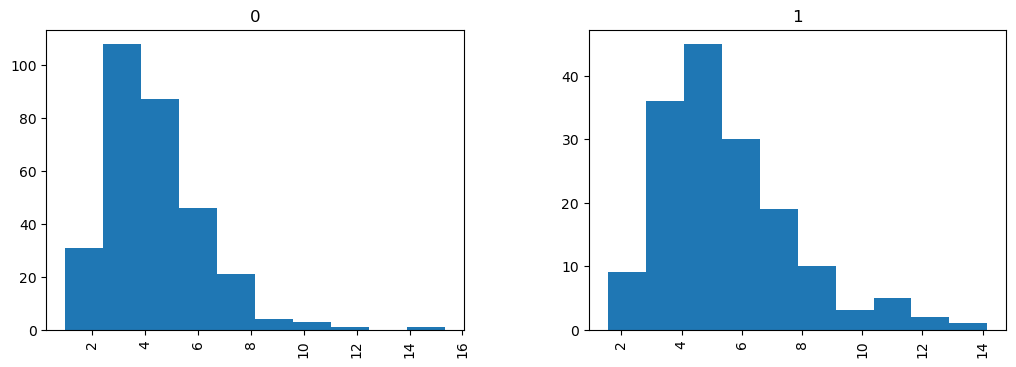

In [2]:
#overview of ldl and how  the average is different for chd and non chd gorups
summary_stats = (chd.loc[:, ["chd", "ldl"]]
                         .groupby("chd")
                         .agg(["mean", "std", "count"]))
summary_stats

ldl_df = chd[["ldl", "chd"]]
ldl_df.hist("ldl", by="chd", figsize=(12, 4))

y0 = ldl_df.loc[ldl_df["chd"]==0]['ldl']
y1 = ldl_df.loc[ldl_df["chd"]==1]["ldl"]


In [3]:
random_seed = 100
cores = 4

μ_prior = chd['ldl'].mean()
σ_prior = chd['ldl'].std() * 2

# prior for Std
σ_low = 1
σ_high = 100

with pm.Model() as model:
    CHD0_mean = pm.Normal("CHD0_mean", mu=μ_prior, sigma=σ_prior)
    CHD1_mean = pm.Normal("CHD1_mean", mu=μ_prior, sigma=σ_prior)
    CHD0_std = pm.Uniform("CHD0_std", lower=σ_low, upper=σ_high)
    CHD1_std = pm.Uniform("CHD1_std", lower=σ_low, upper=σ_high)
    ν = pm.Exponential("ν", 1/29)
    CHD0 = pm.StudentT("No_CHD", nu=ν, mu=CHD0_mean, sigma=CHD0_std, observed=y0)
    CHD1 = pm.StudentT("CHD", nu=ν, mu=CHD1_mean, sigma=CHD1_std, observed=y1)
    diff_of_means = pm.Deterministic("difference of means", CHD0_mean - CHD1_mean)
    diff_of_stds = pm.Deterministic("difference of stds", CHD0_std - CHD1_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((CHD0_std ** 2 + CHD1_std ** 2) / 2)
    )

    chd_trace=pm.sample(random_seed = random_seed, cores = cores)


C:\Users\addyg\anaconda3\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\addyg\anaconda3\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CHD0_mean, CHD1_mean, CHD0_std, CHD1_std, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1008 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
CHD0_mean,4.139,0.102,3.942,4.329,0.002,0.001,3402.0,3218.0,1.0
CHD1_mean,5.226,0.166,4.931,5.551,0.003,0.002,3343.0,2916.0,1.0
CHD0_std,1.490,0.094,1.316,1.665,0.002,0.001,3107.0,2605.0,1.0
CHD1_std,1.803,0.143,1.526,2.065,0.003,0.002,2857.0,2457.0,1.0
ν,5.989,1.702,3.470,8.971,0.038,0.029,2436.0,2324.0,1.0
difference of means,-1.087,0.189,-1.446,-0.744,0.003,0.002,3498.0,2644.0,1.0
difference of stds,-0.313,0.148,-0.596,-0.039,0.002,0.002,4279.0,2878.0,1.0
effect size,-0.658,0.117,-0.881,-0.444,0.002,0.001,3432.0,2886.0,1.0


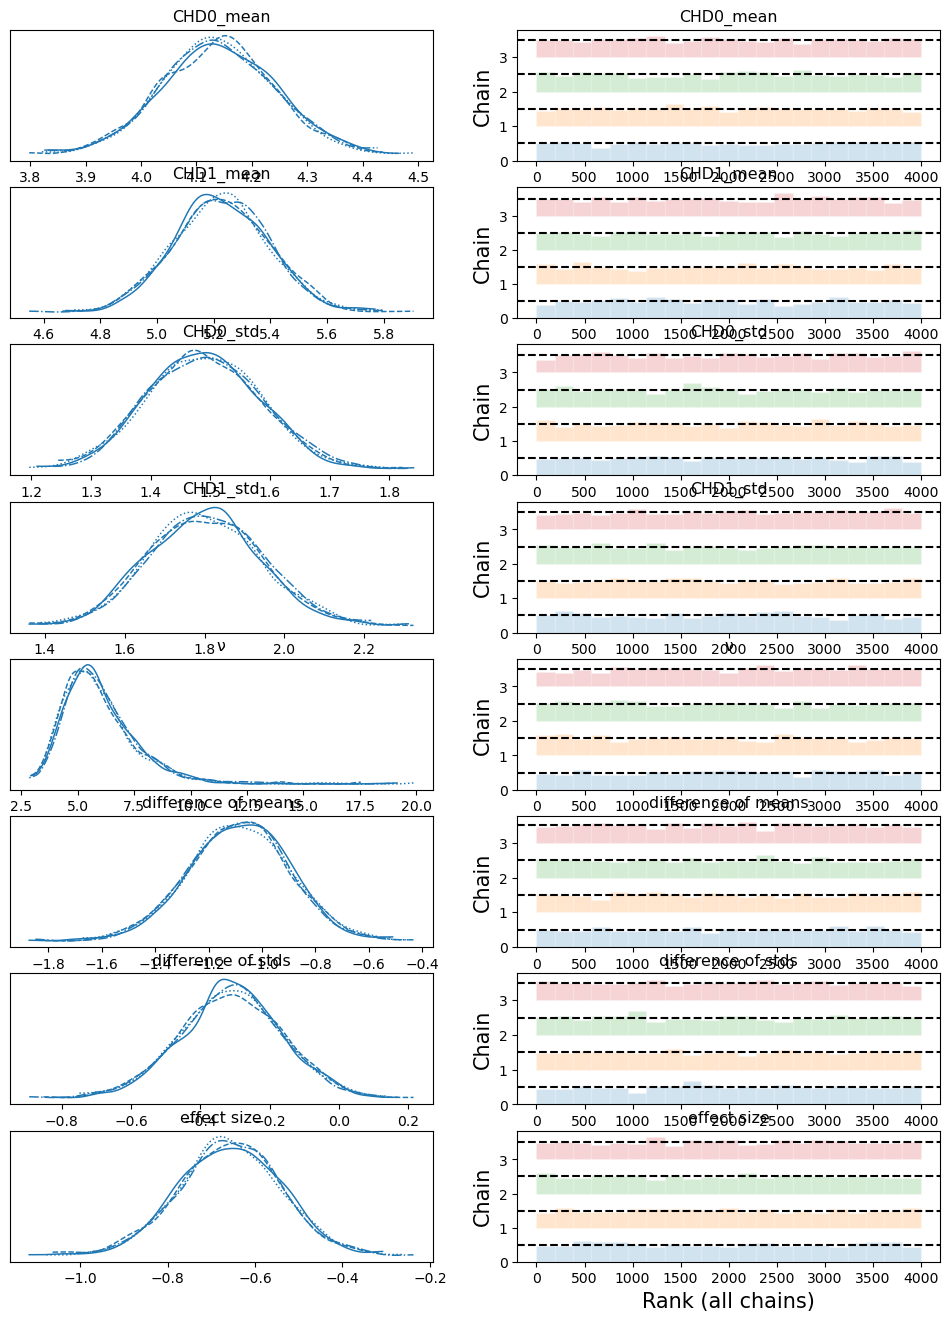

In [4]:
az.plot_trace(chd_trace, kind = "rank_bars")
az.summary(chd_trace)


Sampling: [CHD, No_CHD]


array([<Axes: title={'center': 'No_CHD / No_CHD'}>,
       <Axes: title={'center': 'CHD / CHD'}>], dtype=object)

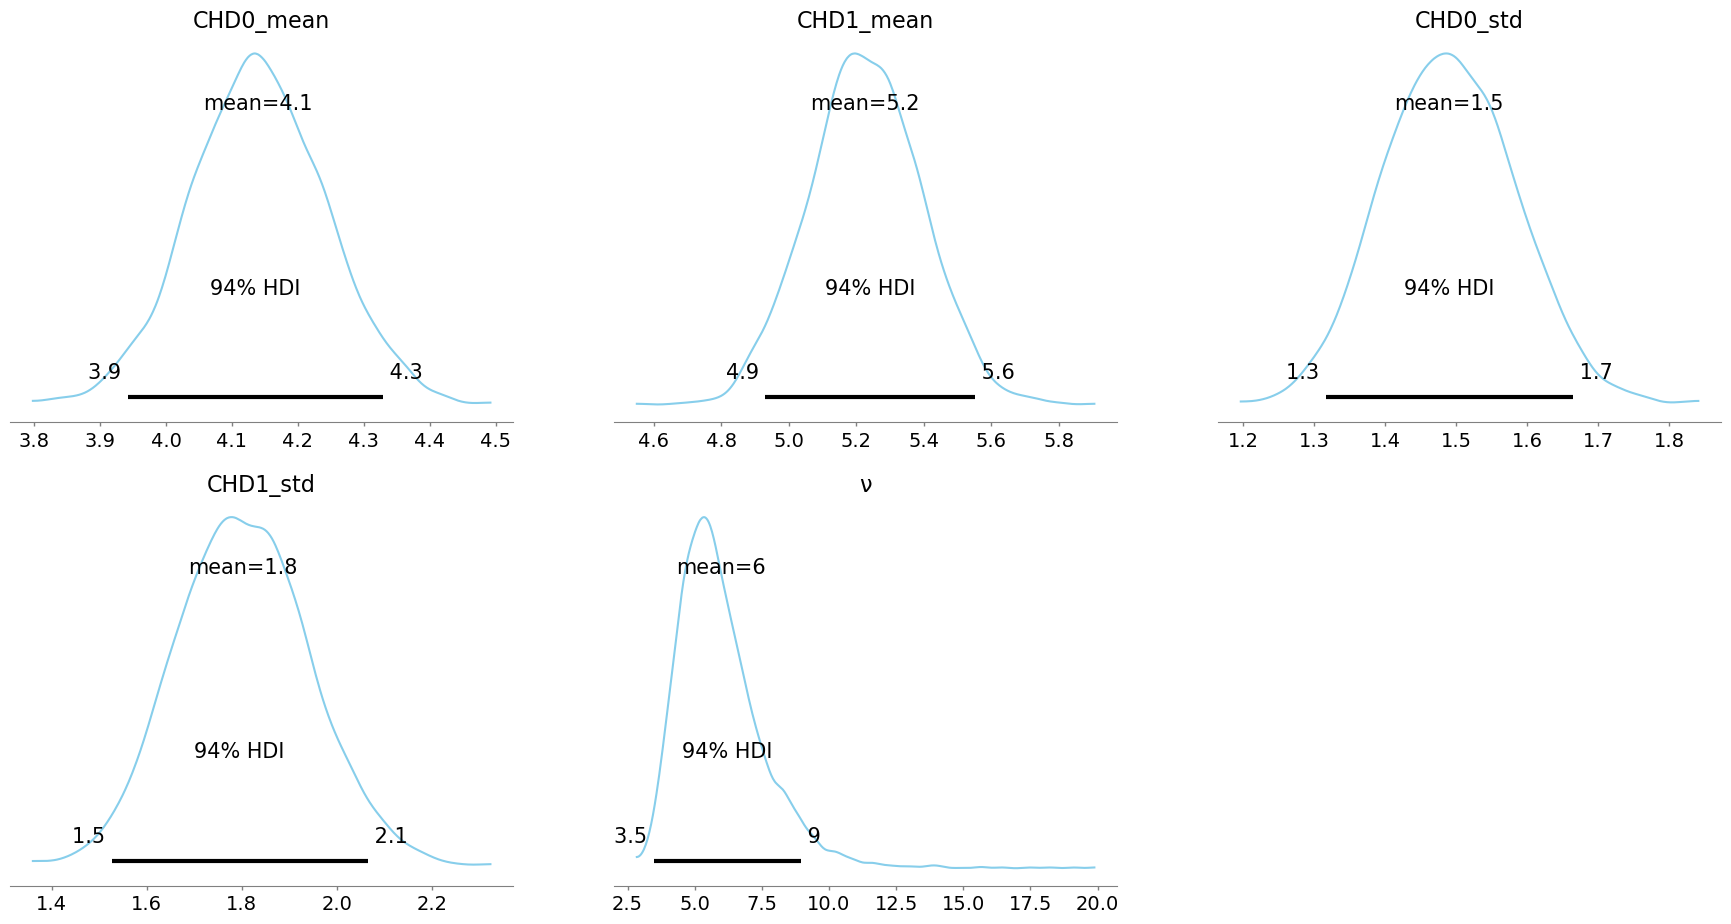

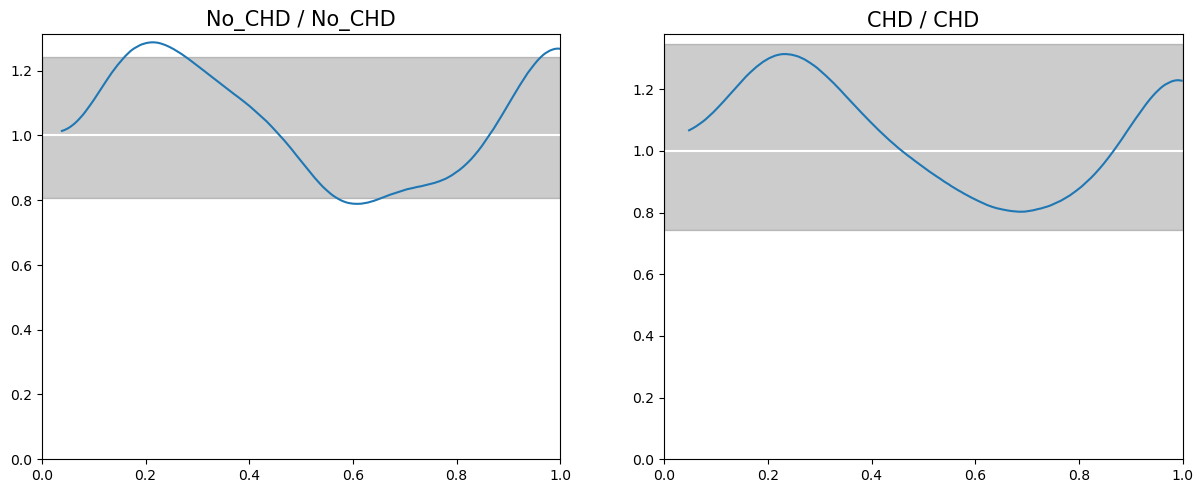

In [5]:
az.plot_posterior(
    chd_trace,
    var_names=["CHD0_mean", "CHD1_mean", "CHD0_std", "CHD1_std", "ν"],
    color="#87ceeb",
);
chd_pp = pm.sample_posterior_predictive(chd_trace, model = model)

az.plot_bpv(chd_pp)


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

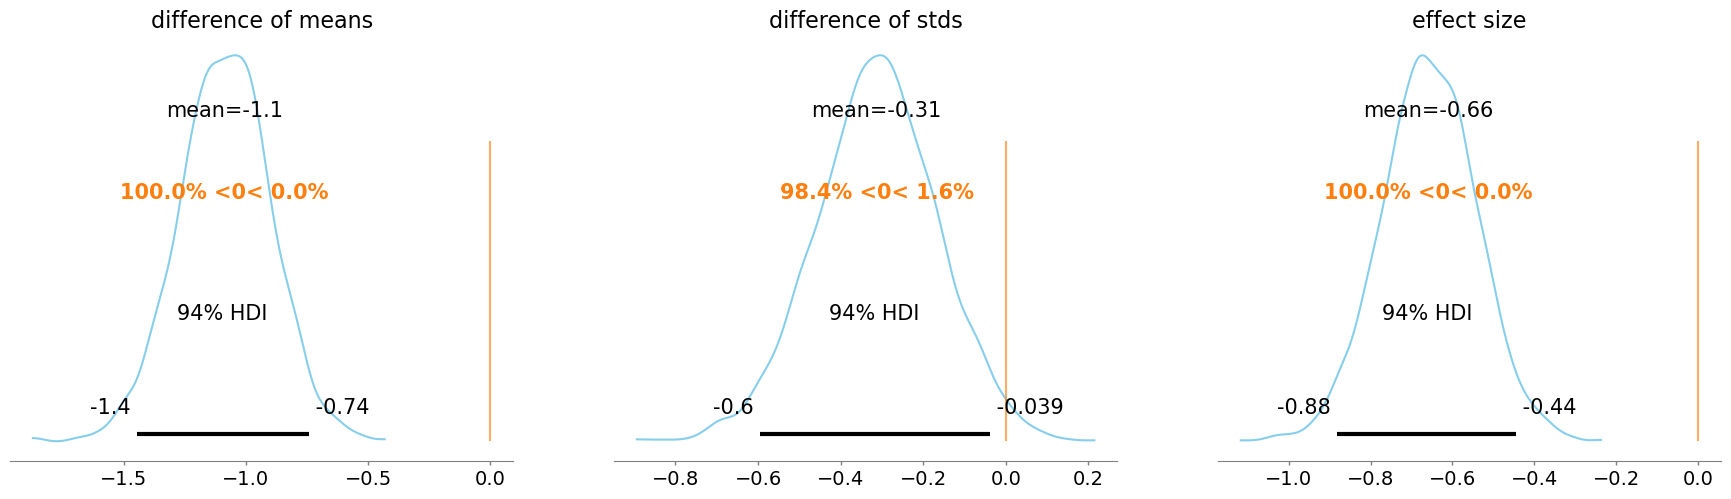

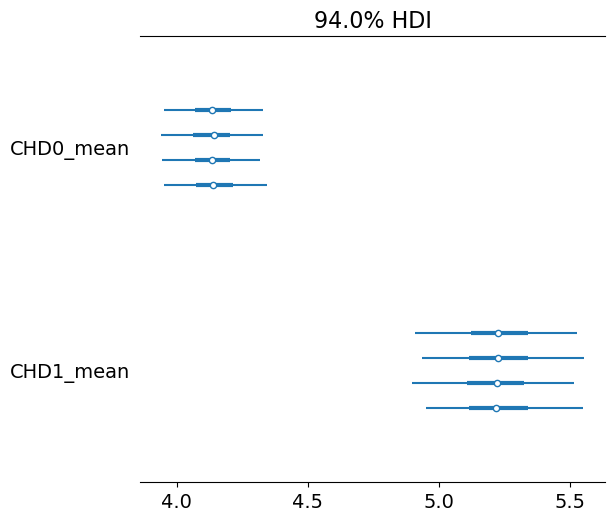

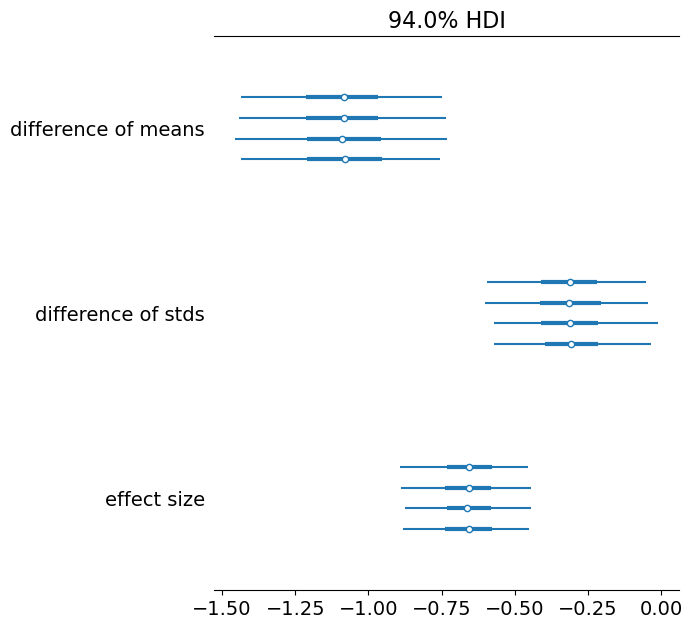

In [6]:
az.plot_posterior(
    chd_trace,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
);
az.plot_forest(chd_trace, var_names = ['CHD0_mean','CHD1_mean'])
az.plot_forest(chd_trace, var_names=["difference of means", "difference of stds", "effect size"])


Based on the various plotes above, there is a clear difference in likelyhood to develop CHD between groups with lower and higher LDL contnet. In particular, the 94% HDI of the posterior difference of means shows that group with higher mean LDL content is more likely to have CHD. The same can be seen with the secondary 94%HDI  set of graphs, and the subsequenmt difference of means graph. The effect size, in addition to the difference of means, seems to show the same general trends as well. 

2. A) :  (a) Perform exploratory data analysis (EDA) to include as minimum a
 review of the summary statistics for the data. Brie y explain how
 this EDA informs the next steps of your work.

In [17]:
algae_train = pd.read_csv('algae.csv', header=0)
algae_test = pd.read_csv('algaeTest.csv', header=0)

In [18]:
algae_train

,season,size,speed,mxPH,mnO2,Cl,NO3,NH4,oPO4,PO4,Chla,a1,a2,a3,a4,a5,a6,a7
0,winter,small,medium,8.00,9.8,60.800,6.238,578.00000,105.000,170.00000,50.000,0.0,0.0,0.0,0.0,34.2,8.3,0.0
1,spring,small,medium,8.35,8.0,57.750,1.288,370.00000,428.750,558.75000,1.300,1.4,7.6,4.8,1.9,6.7,0.0,2.1
2,autumn,small,medium,8.10,11.4,40.020,5.330,346.66699,125.667,187.05701,15.600,3.3,53.6,1.9,0.0,0.0,0.0,9.7
3,spring,small,medium,8.07,4.8,77.364,2.302,98.18200,61.182,138.70000,1.400,3.1,41.0,18.9,0.0,1.4,0.0,1.4
4,autumn,small,medium,8.06,9.0,55.350,10.416,233.70000,58.222,97.58000,10.500,9.2,2.9,7.5,0.0,7.5,4.1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,autumn,large,medium,8.40,8.4,17.375,3.833,83.75000,53.625,79.75000,2.338,12.7,21.7,5.6,0.0,1.0,0.0,0.0
196,spring,large,medium,8.30,10.6,14.320,3.200,125.33300,35.333,75.90400,4.667,18.0,7.0,1.7,0.0,4.8,10.3,1.0
197,autumn,large,medium,8.20,7.0,139.989,2.978,60.11000,78.333,140.22000,31.738,0.0,15.9,2.4,1.0,0.0,0.0,0.0
198,winter,large,medium,8.00,7.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.5,3.7,1.0,0.0,0.0,4.9


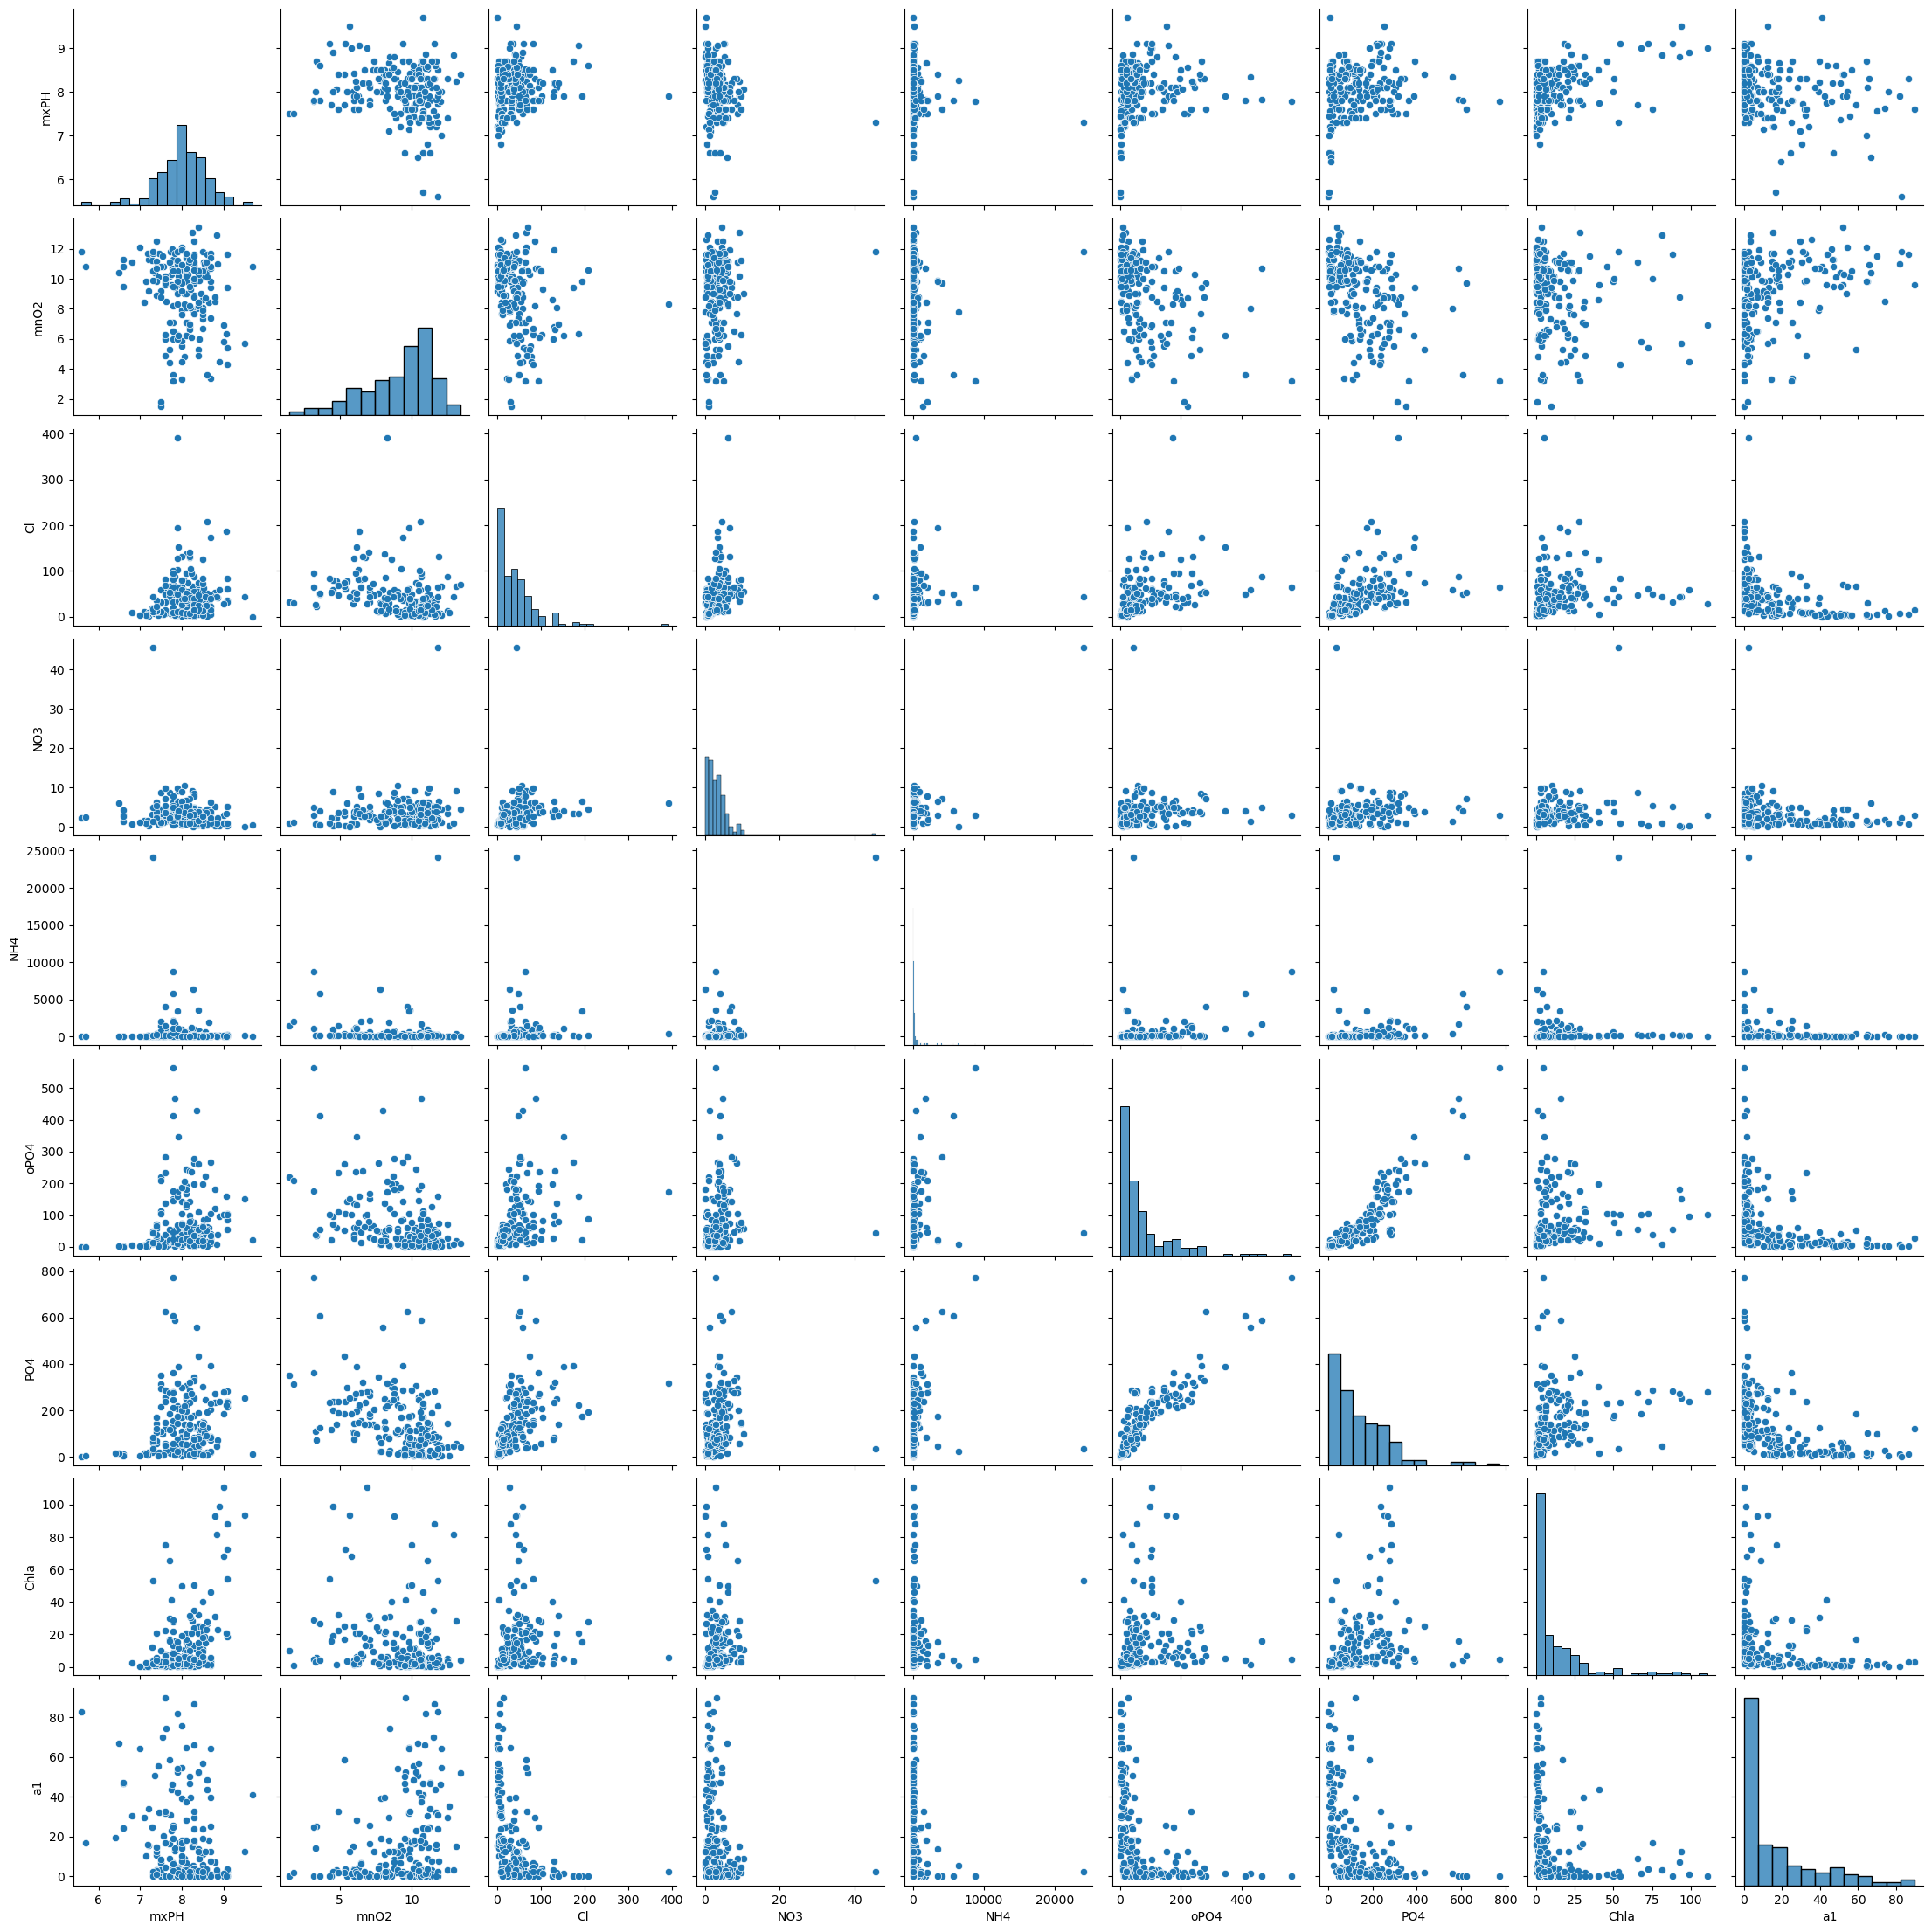

In [19]:
# EGA: checking pairwise comparisions between each variable of interest
sns.pairplot(algae_train,vars= ['mxPH' ,'mnO2' ,'Cl' ,'NO3' ,'NH4' ,'oPO4' ,'PO4' ,'Chla', 'a1' ])


<Axes: xlabel='speed', ylabel='a1'>

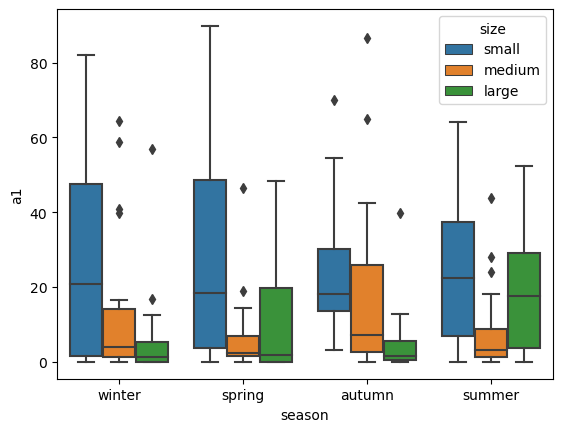

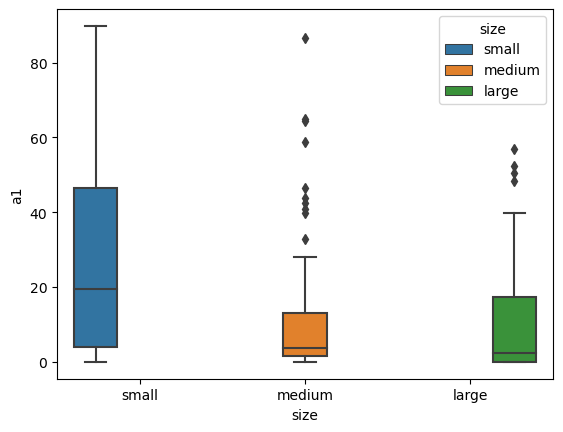

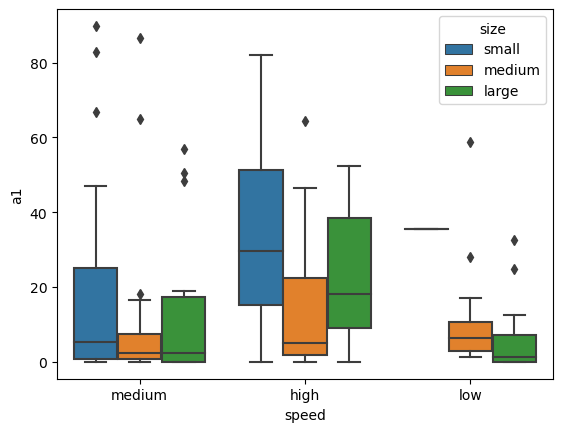

In [20]:
#Performing analysis of categorical variables againt the response
sns.boxplot(data=algae_train, x="season", y="a1", hue = 'size')
plt.figure()
sns.boxplot(data=algae_train, x="size", y="a1", hue = 'size')
plt.figure()
sns.boxplot(data=algae_train, x="speed", y="a1", hue = 'size')


#fasdt serts gahs THESE ARE MY COMMENTS ON THE EDA

b) Clean the data by identifying missing values and use the following
 strategy to estimate missing values: 1. For continuous (real-valued)
 data use the mean; 2. For discrete (integer valued) use the median;
 and 3. For categorical or nominal data use the mode. Then scale the
 predictor variables (subtract the mean and divide by the standard
 deviation) and code the categorical variables. Explain why you are
 doing this. Reparameterize the response variable using a log trans
form and explain why you are doing this.

In [21]:
#drop unneed vars
algae_train.drop(['a2','a3','a4','a5','a6','a7'], axis = 1, inplace = True)

In [22]:
pd.isnull(algae_train).any()

season    False
size      False
speed     False
mxPH       True
mnO2       True
Cl         True
NO3        True
NH4        True
oPO4       True
PO4        True
Chla       True
a1        False
dtype: bool

In [23]:
# Continuous (real-valued) columns with missing data
continuous_missing_columns = ['mxPH', 'mnO2', 'Cl', 'NO3', 'NH4', 'oPO4', 'PO4', 'Chla']

# Impute using the mean
for column in continuous_missing_columns:
    algae_train[column].fillna(algae_train[column].mean(), inplace=True)
    
algae_train



,season,size,speed,mxPH,mnO2,Cl,NO3,NH4,oPO4,PO4,Chla,a1
0,winter,small,medium,8.00,9.8,60.800000,6.238000,578.000000,105.000000,170.000000,50.000000,0.0
1,spring,small,medium,8.35,8.0,57.750000,1.288000,370.000000,428.750000,558.750000,1.300000,1.4
2,autumn,small,medium,8.10,11.4,40.020000,5.330000,346.666990,125.667000,187.057010,15.600000,3.3
3,spring,small,medium,8.07,4.8,77.364000,2.302000,98.182000,61.182000,138.700000,1.400000,3.1
4,autumn,small,medium,8.06,9.0,55.350000,10.416000,233.700000,58.222000,97.580000,10.500000,9.2
...,...,...,...,...,...,...,...,...,...,...,...,...
195,autumn,large,medium,8.40,8.4,17.375000,3.833000,83.750000,53.625000,79.750000,2.338000,12.7
196,spring,large,medium,8.30,10.6,14.320000,3.200000,125.333000,35.333000,75.904000,4.667000,18.0
197,autumn,large,medium,8.20,7.0,139.989000,2.978000,60.110000,78.333000,140.220000,31.738000,0.0
198,winter,large,medium,8.00,7.6,43.636279,3.282389,501.295828,73.590596,137.882101,13.971197,0.0


In [27]:
pd.isnull(algae_train).any()


season    False
size      False
speed     False
mxPH      False
mnO2      False
Cl        False
NO3       False
NH4       False
oPO4      False
PO4       False
Chla      False
a1        False
dtype: bool

NameError: name 'np' is not defined

In [30]:
log_a1 = np.log10(algae_train['a1']+.8) # + 0.8 to deal with log(0) issues

In [31]:
#Getting dummy variables for categorical variables
algae_model_df = pd.get_dummies(algae_train, drop_first = False, dtype = float)
algae_model_df.describe(include = 'all')


,mxPH,mnO2,Cl,NO3,NH4,oPO4,PO4,Chla,a1,season_autumn,season_spring,season_summer,season_winter,size_large,size_medium,size_small,speed_high,speed_low,speed_medium
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,8.011734,9.117778,43.636279,3.282389,501.295828,73.590596,137.882101,13.971197,16.923500,0.200000,0.265000,0.22500,0.310000,0.22500,0.420000,0.355000,0.420000,0.165000,0.415000
std,0.596800,2.379206,45.639480,3.757449,1952.658519,90.677307,128.343892,19.868344,21.348376,0.401004,0.442441,0.41863,0.463654,0.41863,0.494797,0.479714,0.494797,0.372112,0.493958
min,5.600000,1.500000,0.222000,0.050000,5.000000,1.000000,1.000000,0.200000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.700000,7.775000,11.066000,1.312000,38.777750,15.900000,42.791750,2.137500,1.500000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.055000,9.800000,35.999000,2.740000,103.333000,41.400000,104.863500,5.983500,6.950000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.400000,10.800000,56.975250,4.420750,229.987500,97.999750,213.250000,17.200000,24.800000,0.000000,1.000000,0.00000,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,1.000000
max,9.700000,13.400000,391.500000,45.650000,24064.000000,564.599980,771.599980,110.456000,89.800000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
from sklearn.preprocessing import StandardScaler

# Assuming your data is in algae_model_df and you only want to scale the continuous variables
continuous_columns = ['mxPH', 'mnO2', 'Cl', 'NO3', 'NH4', 'oPO4', 'PO4', 'Chla', 'a1']
scaler = StandardScaler()
algae_model_df[continuous_columns] = scaler.fit_transform(algae_model_df[continuous_columns])
stats.describe(algae_model_df[continuous_columns])


DescribeResult(nobs=200, minmax=(array([-4.05124811, -3.20984981, -0.95363102, -0.86242032, -0.25480197,
       -0.8025465 , -1.06920238, -0.69486184, -0.79471937]), array([ 2.83596231,  1.80437006,  7.64111815, 11.30392725, 12.09726766,
        5.42849744,  4.95004578,  4.86839372,  3.42224518])), mean=array([-1.77635684e-16, -2.66453526e-16,  1.59872116e-16,  2.66453526e-17,
       -4.44089210e-18,  1.33226763e-17, -8.88178420e-18, -1.06581410e-16,
       -3.55271368e-17]), variance=array([1.00502513, 1.00502513, 1.00502513, 1.00502513, 1.00502513,
       1.00502513, 1.00502513, 1.00502513, 1.00502513]), skewness=array([-0.73219185, -0.89960233,  3.16672959,  7.37721798,  9.54347254,
        2.35283843,  1.68164363,  2.65102626,  1.47058968]), kurtosis=array([  2.08105285,   0.2771346 ,  17.23121701,  79.06950245,
       106.51781108,   6.87198443,   4.18727593,   7.47395136,
         1.35550058]))

In [34]:
algae_model_df

,mxPH,mnO2,Cl,NO3,NH4,oPO4,PO4,Chla,a1,season_autumn,season_spring,season_summer,season_winter,size_large,size_medium,size_small,speed_high,speed_low,speed_medium
0,-0.019710,0.287463,3.770155e-01,0.788574,0.039380,0.347256,0.250877,1.817928e+00,-0.794719,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.568222,-0.470990,3.100197e-01,-0.532115,-0.067408,3.926568,3.287449,-6.393585e-01,-0.728976,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.148270,0.961644,-7.943460e-02,0.546315,-0.079388,0.575746,0.384111,8.218554e-02,-0.639753,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.097876,-1.819352,7.408577e-01,-0.261574,-0.206962,-0.137187,0.006389,-6.343127e-01,-0.649145,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.081078,-0.049627,2.573017e-01,1.903289,-0.137386,-0.169912,-0.314805,-1.751483e-01,-0.362692,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.652213,-0.302445,-5.768510e-01,0.146906,-0.214371,-0.220735,-0.454077,-5.869834e-01,-0.198334,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
196,0.484232,0.624554,-6.439566e-01,-0.021982,-0.193022,-0.422968,-0.484118,-4.694676e-01,0.050552,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
197,0.316251,-0.892353,2.116468e+00,-0.081213,-0.226508,0.052431,0.018262,8.964706e-01,-0.794719,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
198,-0.019710,-0.639535,1.560767e-16,0.000000,0.000000,0.000000,0.000000,-8.963074e-17,-0.794719,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


Why I'm doing this: 
Handling missing values is pivotal in data preprocessing. Missing entries in datasets, often a result of data collection discrepancies or inherent gaps, can skew results. For continuous data, imputing with the mean maintains the dataset's original distribution, ensuring no undue bias. For discrete data, the median is used since it's robust against outliers. For categorical data, the mode, being the most frequent category, offers a representative fill.

Scaling predictor variables is essential for distance-based algorithms like k-means or k-nearest neighbors. If features vary in scale, those with broader ranges might unfairly influence the algorithm. Subtracting the mean from each feature centers the data around zero, and dividing by the standard deviation ensures all feature values lie within a consistent range.

Categorical variables are encoded to provide machine learning algorithms with numerical inputs. One common method is one-hot encoding, converting categorical data into a machine-friendly format.

Lastly, the response variable undergoes a log transformation. This can stabilize variances, make data more resemble a normal distribution, and better satisfy model assumptions like linearity and homoscedasticity.

In essence, these steps make the dataset more suitable for building accurate and insightful machine learning models.

(c) Build a robust Bayesian regression model to predict the response and
 explain your choices for the priors.

In [41]:
import pymc3 as pm

# Splitting predictors and response
X_algae = algae_model_df.drop('a1', axis=1).values
log_a1 = algae_model_df['a1'].values  # Assuming 'a1' values are already log-transformed. If not, apply np.log() here.
k = X_algae.shape[1]

a1_mean = log_a1.mean()

with pm.Model() as algae_lin_model:
    
    # Data
    X = pm.Data("X", X_algae)  # using Data instead of MutableData for simplicity
    y = pm.Data("y", log_a1)
    
    # Regression model parameters
    α = pm.Normal('α', mu=a1_mean, sigma=1)  # informed prior
    β = pm.MvNormal('β', mu=np.zeros(k), cov=np.eye(k), shape=k)
    
    # Likelihood parameters
    nu = pm.Exponential('nu', 1/29.0) + 1  # uninformed prior
    σ = pm.HalfStudentT('σ', nu=2, sigma=8)
    μ = α + pm.math.dot(X, β)
    
    # Likelihood
    log_algae_obs = pm.StudentT('log_algae_obs', nu=nu, mu=μ, sigma=σ, observed=y)
    chd_trace=pm.sample(random_seed = random_seed, cores = cores)



C:\Users\addyg\AppData\Roaming\Python\Python310\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\addyg\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\addyg\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\addyg\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60639 seconds.


AttributeError: module 'arviz' has no attribute 'from_pymc3'

In [42]:

# To visualize the model
g1 = pm.model_to_graphviz(algae_lin_model)
g1.view()

az.plot_trace(algae_lin_model, kind = 'rank_bars', compact = False)


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

 (e) Plot the posterior distributions for the parameters and discuss your
 results. Plot the response variable vs. one of the predictors using
 counterfactuals and discuss this plot.

In [ ]:
with algae_lin_model:
    trace= pm.sample(random_seed = random_seed, return_inferencedata=False)
    algae_lin_trace = pm.to_inference_data(trace=trace, log_likelihood=True)


az.plot_trace(algae_lin_trace)